# Lab 10: Dialogue Act Tagging

Dialogue act (DA) tagging is an important step in the process of developing dialog systems. DA tagging is a problem usually solved by supervised machine learning approaches that all require large amounts of hand labeled data. A wide range of techniques have been investigated for DA tagging. In this lab, we explore two approaches to DA classification. We are using the Switchboard Dialog Act Corpus for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [1]:
import pandas as pd
import glob
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
!unzip swda.zip

Archive:  swda.zip
   creating: swda/
  inflating: swda/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/swda/
  inflating: __MACOSX/swda/._.DS_Store  
   creating: swda/sw00utt/
  inflating: swda/sw00utt/sw_0001_4325.utt.csv  
   creating: __MACOSX/swda/sw00utt/
  inflating: __MACOSX/swda/sw00utt/._sw_0001_4325.utt.csv  
  inflating: swda/sw00utt/sw_0002_4330.utt.csv  
  inflating: swda/sw00utt/sw_0003_4103.utt.csv  
  inflating: swda/sw00utt/sw_0004_4327.utt.csv  
  inflating: swda/sw00utt/sw_0005_4646.utt.csv  
  inflating: swda/sw00utt/sw_0006_4108.utt.csv  
  inflating: swda/sw00utt/sw_0007_4171.utt.csv  
  inflating: swda/sw00utt/sw_0008_4321.utt.csv  
  inflating: swda/sw00utt/sw_0009_4329.utt.csv  
  inflating: swda/sw00utt/sw_0010_4356.utt.csv  
  inflating: swda/sw00utt/sw_0011_4358.utt.csv  
  inflating: swda/sw00utt/sw_0012_4360.utt.csv  
  inflating: swda/sw00utt/sw_0013_4617.utt.csv  
  inflating: swda/sw00utt/sw_0014_4619.utt.csv  
  inflating: swda/sw00u

In [3]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


In [4]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [5]:
reduced_df = result[['act_tag','text']]


Reduce down the number of tags to 43 - converting the combined tags to their generic classes:

In [6]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [7]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


There are 43 tags in this dataset. Some of the tags are Yes-No-Question('qy'), Statement-non-opinion('sd') and Statement-opinion('sv'). Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


To get unique tags:

In [8]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [9]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


In [10]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create utterance representations as sequences of words:

In [11]:
utterances = []
for i in range(0, len(reduced_df)):
    utterances.append(reduced_df['text'].iloc[i].split(" "))


In [12]:
wordvectors = {}
index = 1
for u in utterances:
    for w in u:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [13]:
# Max length of 137
MAX_LENGTH = len(max(utterances, key=len))

In [14]:
utterance_embeddings = []
for u in utterances:
    utterance_emb = []
    for w in u:
        utterance_emb.append(wordvectors[w])
    utterance_embeddings.append(utterance_emb)


Then we split the dataset into test and train.

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(utterance_embeddings, np.array(tags_encoding), shuffle = False)


And pad the utterances with zero to make all utterances of equal length.


In [16]:
MAX_LENGTH = 137

In [17]:
from keras.preprocessing.sequence import pad_sequences
 
train_utterances_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_utterances_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

In [18]:


train_input = train_utterances_X[:140000]
val_input = train_utterances_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]


# Model 1 - 

The first approach we'll try is to treat DA tagging as a standard multi-class text classification task, in the way you've done before with sentiment analysis and other tasks. Each utterance will be treated independently as a text to be classified with its DA tag label. This model has an architecture of:

- Embedding  
- BLSTM  
- Fully Connected Layer
- Softmax Activation

 The model architecture is as follows: Embedding Layer (to generate word embeddings) Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get the probabilities.


In [19]:
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(utterances, key=len))
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

In [20]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from keras.optimizers import Adam

#Building the network

# Include 2 BLSTM layers, in order to capture both the forward and backward hidden states

# Embedding layer
# Bidirectional 1
# Bidirectional 2
# Dense layer
# Activation
# embedding_layer = Embedding(mask_zero = False, input_dim = VOCAB_SIZE, output_dim = EMBED_SIZE, input_length = MAX_LENGTH, embeddings_initializer='glorot_uniform')
# lstm_layer_1 = Bidirectional(LSTM(86, return_sequences = False))(embedding_layer)
# lstm_layer_2 = Bidirectional(LSTM(86, return_sequences = False))(lstm_layer_1)
# dense_layer = Dense(43)(lstm_layer_2)
# activation_layer = Activation('softmax')(dense_layer)
# model = Model(inputs= embedding_layer, outputs=activation_layer)
model = Sequential(
    [
     Embedding(mask_zero = False, input_dim = VOCAB_SIZE + 1, output_dim = EMBED_SIZE, input_length = MAX_LENGTH),
     Bidirectional(LSTM(43, return_sequences = True)),
     Bidirectional(LSTM(43, return_sequences = False)),
     Dense(HIDDEN_SIZE),
     Activation('softmax')
    ]
)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 137, 100)          4373200   
_________________________________________________________________
bidirectional (Bidirectional (None, 137, 86)           49536     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 86)                44720     
_________________________________________________________________
dense (Dense)                (None, 43)                3741      
_________________________________________________________________
activation (Activation)      (None, 43)                0         
Total params: 4,471,197
Trainable params: 4,471,197
Non-trainable params: 0
_________________________________________________________________


<font color = "#75a2eb"><b> Here we are creating a sequential model with the embedding layer as the first layer. That layer takes the vocab size as input plus an additional 1 because 0 index has a 0 vector and we lose a word in the matrix. the output dimension is the embedding size while the input_length is the max padding length. We follow that by two Bidirectional LSTM layers with 43 size. One has return sequences as True while the other is False. We follow that with a Dense Layer with hidden_size and the output layer is an acitvation layer with softmax activation function.</b></font>

In [21]:
# Train the model - using validation 
history = model.fit(train_input,
                    train_labels,
                    epochs=3,
                    batch_size=256,
                    validation_data=(val_input, val_labels),
                    verbose=1)

Epoch 1/3
547/547 [==============================] - 149s 208ms/step - loss: 1.9365 - accuracy: 0.4925 - val_loss: 1.2120 - val_accuracy: 0.6469
Epoch 2/3
547/547 [==============================] - 111s 204ms/step - loss: 1.1206 - accuracy: 0.6752 - val_loss: 1.0291 - val_accuracy: 0.7029
Epoch 3/3
547/547 [==============================] - 112s 205ms/step - loss: 0.9229 - accuracy: 0.7321 - val_loss: 0.9755 - val_accuracy: 0.7152


In [22]:
score = model.evaluate(test_utterances_X, y_test, batch_size=100)

560/560 [==============================] - 32s 58ms/step - loss: 1.1058 - accuracy: 0.6714


In [23]:
print("Overall Accuracy:", score[1]*100)


Overall Accuracy: 67.1371340751648


## Evaluation


The overall accuracy is 67%, an effective accuracy for this task.

In addition to overall accuracy, you need to look at the accuracy of some minority classes. Signal-non-understanding ('br') is a good indicator of "other-repair" or cases in which the other conversational participant attempts to repair the speaker's error. Summarize/reformulate ('bf') has been used in dialogue summarization. Report the accuracy for these classes and some frequent errors you notice the system makes in predicting them. What do you think the reasons are？

## Minority Classes

In [24]:
# Decoding dictionary
decoding_dic= {}

for i in one_hot_encoding_dic.columns:
 decoding_dic[np.argmax(one_hot_encoding_dic[i])] = i

Classes_names = []
for i in range(len(decoding_dic.items())):
  Classes_names.append(decoding_dic[i])
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(25, 25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [25]:
# Generate predictions for the test data
test_predictions = model.predict_classes(test_utterances_X, batch_size = 100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


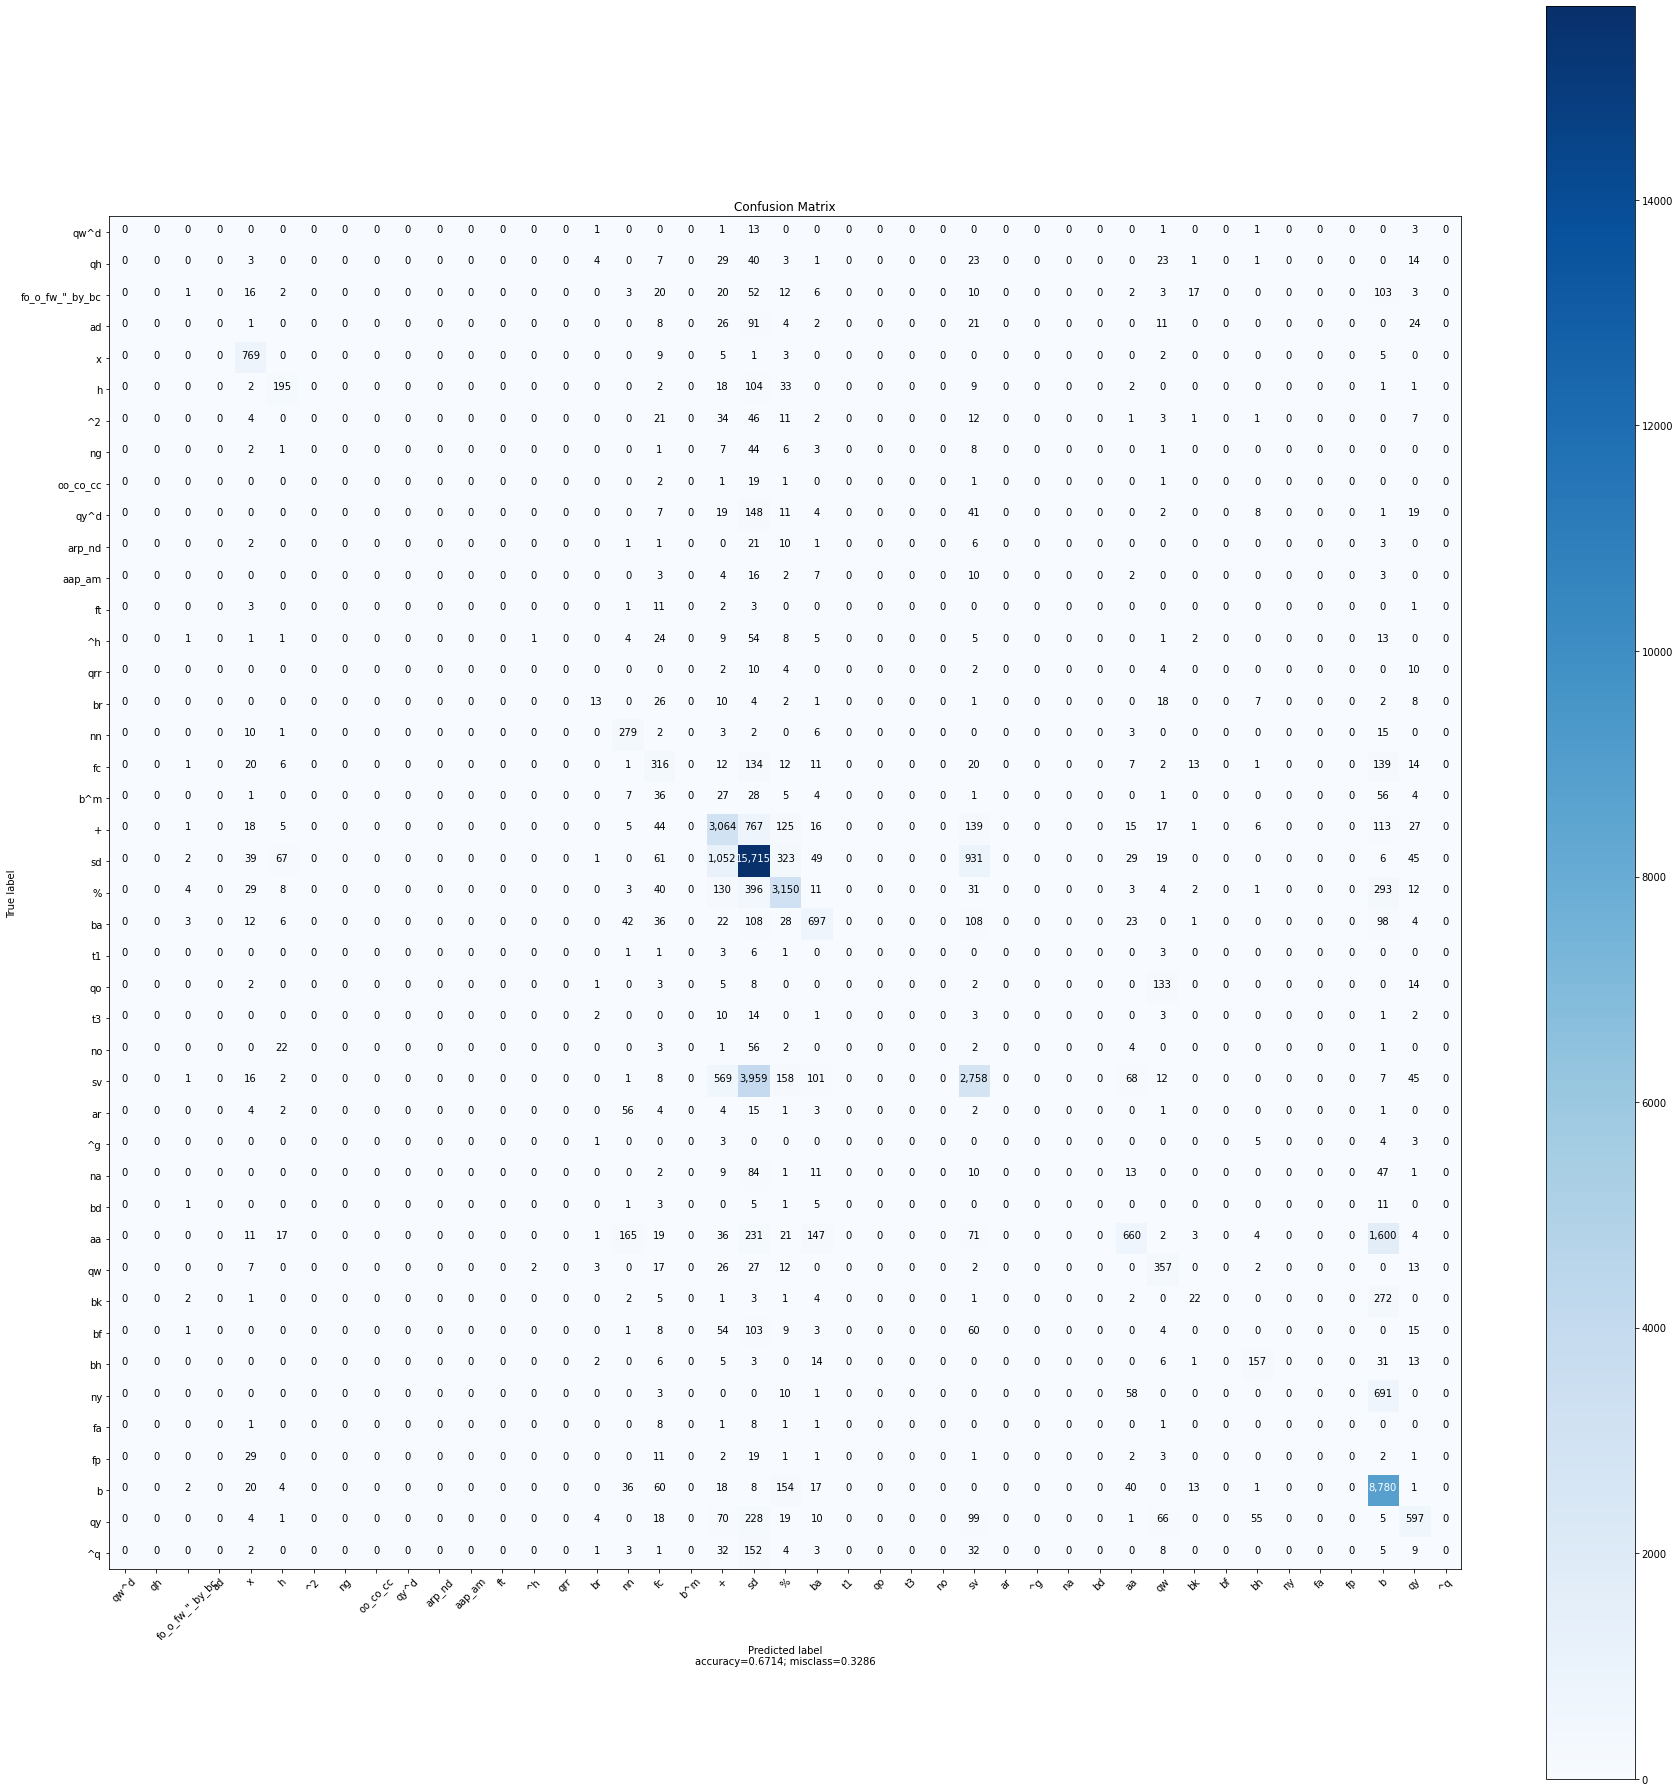

In [26]:
# Build the confusion matrix off these predictions
rounded_labels = np.argmax(y_test, axis=1)
cm=sklearn.metrics.confusion_matrix(rounded_labels,test_predictions)
plot_confusion_matrix(cm,normalize    = False,
                      target_names = Classes_names,
                      title        = "Confusion Matrix")

In [27]:
# Calculate Accuracies for "br" and "bf"
def Cal_Accuracy_Minority(class_name,ConfusionMatrix):

    # Finding position of class in confusion Matrix
    Position = np.argmax(one_hot_encoding_dic[class_name])
    print('Position:',Position)

    # Finding True positive
    TP_minority = ConfusionMatrix[Position][Position]

    # Total instances

    instances = 0 
    for i in range(len(ConfusionMatrix)):

        instances += ConfusionMatrix[Position][i]

    print('Instance :', instances)

    # Accuracy

    Accuracy_min = TP_minority/instances

    return Accuracy_min

# Calculate Accuracies for "br" and "bf" for imbalanced data
accuracy_br = Cal_Accuracy_Minority('br',cm)
accuracy_bf = Cal_Accuracy_Minority('bf',cm)
print('accuracy of br is :',accuracy_br)
print('accuracy of bf is :',accuracy_bf)


Position: 15
Instance : 92
Position: 35
Instance : 258
accuracy of br is : 0.14130434782608695
accuracy of bf is : 0.0


<font color = "#75a2eb"><b> As expected the Accuracy for br and bf which are minority classes is extremely low. There are not many samples for the model to be confident about classifying them.</b></font>


Due to the reduced lack of training data for the minority classes, these minority classifiers will not be very confident in classification, as they have not been fully optimised. The frequent classifiers will be more optimised and will generate more confident scores for all examples, effectively crowding out the less confident minority classifiers. 




# Model 2 - Balanced Network


One thing we can do to try to improve performance is therefore to balance the data more sensibly. As the dataset is highly imbalanced, we can simply weight the loss function in training, to weight up the minority classes proportionally to their underrepresentation. 

In [28]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

## Define & Train the model

In [29]:
# Re-built the model for the balanced training
model_balanced = Sequential(
    [
     Embedding(mask_zero = False, input_dim = VOCAB_SIZE + 1, output_dim = EMBED_SIZE, input_length = MAX_LENGTH, embeddings_initializer='glorot_uniform'),
     Bidirectional(LSTM(43, return_sequences = True)),
     Bidirectional(LSTM(43, return_sequences = False)),
     Dense(HIDDEN_SIZE),
     Activation('softmax')
    ]
)
model_balanced.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model_balanced.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 137, 100)          4373200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 137, 86)           49536     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 86)                44720     
_________________________________________________________________
dense_1 (Dense)              (None, 43)                3741      
_________________________________________________________________
activation_1 (Activation)    (None, 43)                0         
Total params: 4,471,197
Trainable params: 4,471,197
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Train the balanced network -  takes  time to achieve good accuracy
history = model_balanced.fit(train_input,
                    train_labels,
                    epochs=3,
                    batch_size=256,
                    validation_data=(val_input, val_labels),
                    class_weight = d_class_weights,
                    verbose=1)

Epoch 1/3
547/547 [==============================] - 119s 207ms/step - loss: 3.4670 - accuracy: 0.1041 - val_loss: 2.6928 - val_accuracy: 0.2970
Epoch 2/3
547/547 [==============================] - 111s 203ms/step - loss: 2.4659 - accuracy: 0.3329 - val_loss: 2.2352 - val_accuracy: 0.3777
Epoch 3/3
547/547 [==============================] - 113s 206ms/step - loss: 1.9268 - accuracy: 0.3981 - val_loss: 2.0741 - val_accuracy: 0.4086


<font color = "#75a2eb"><b> The model is same as before. However, during training here we are assigning more weights to the minority classes to help in better predictions.</b></font>

## Test the model

In [31]:
# Overall Accuracy
score = model_balanced.evaluate(test_utterances_X, y_test, batch_size=100)

560/560 [==============================] - 32s 57ms/step - loss: 2.1721 - accuracy: 0.3879


In [32]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 38.78931105136871


In [33]:
# Generate predictions for the test data
label_pred = model_balanced.predict(test_utterances_X, batch_size=100)

## Balanced network evaluation

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

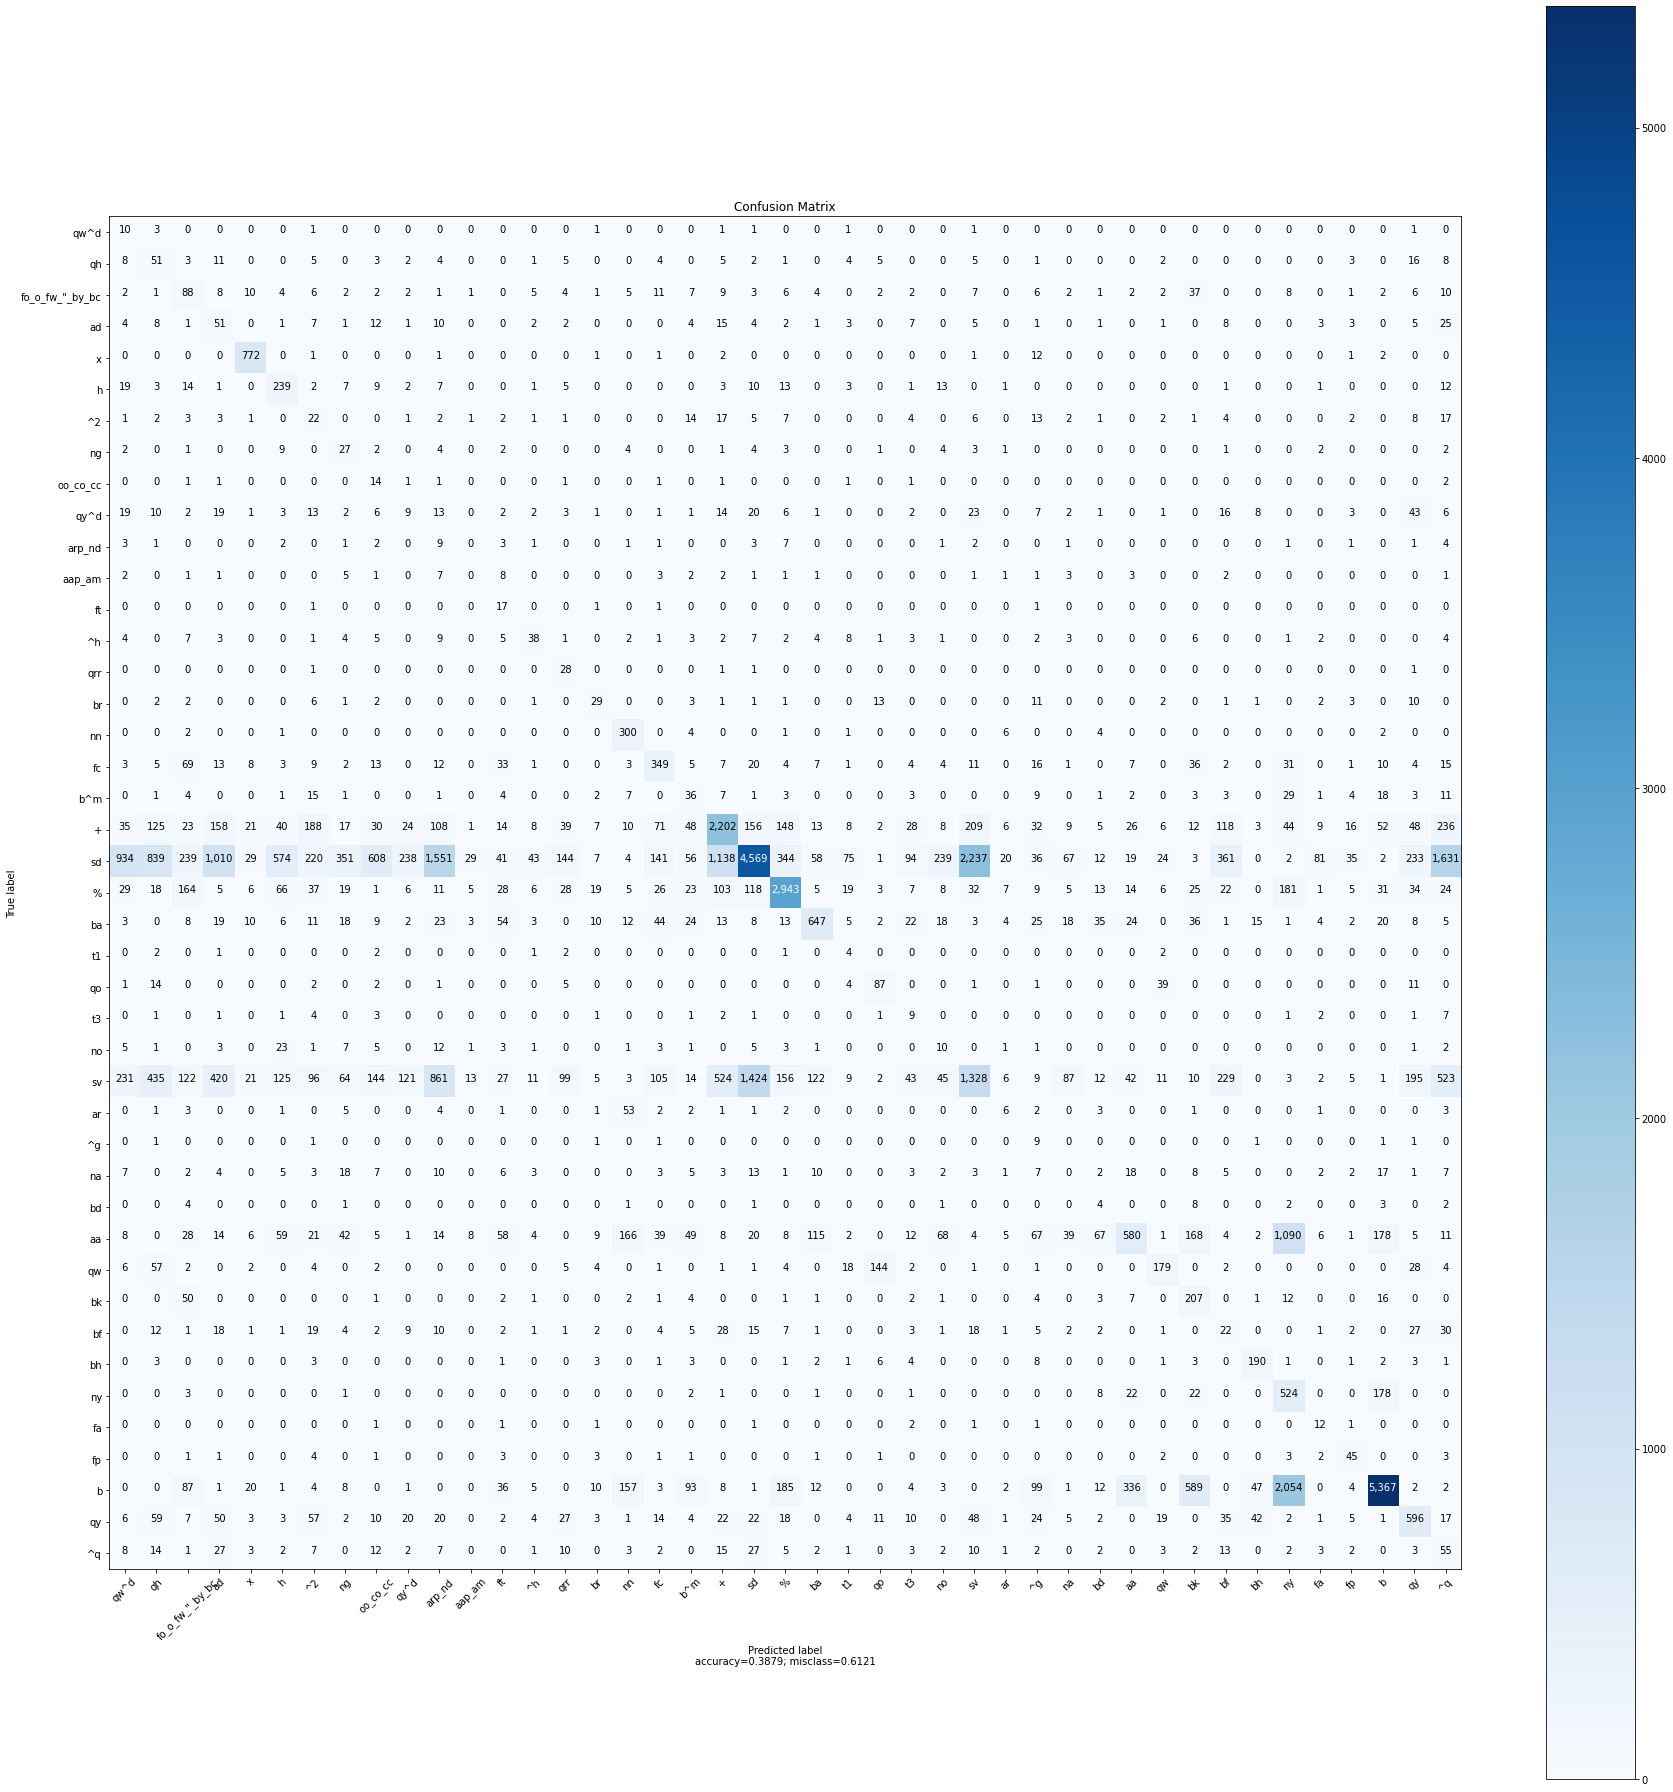

Position: 15
Instance : 92
Position: 35
Instance : 258
accuracy of br is : 0.31521739130434784
accuracy of bf is : 0.08527131782945736


In [34]:
# Build the confusion matrix off these predictions

matrix_balanced = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))
plot_confusion_matrix(matrix_balanced,normalize    = False,
                      target_names = Classes_names,
                      title        = "Confusion Matrix")
# Calculate Accuracies for "br" and "bf"
accuracy_br = Cal_Accuracy_Minority('br',matrix_balanced)
accuracy_bf = Cal_Accuracy_Minority('bf',matrix_balanced)
print('accuracy of br is :',accuracy_br)
print('accuracy of bf is :',accuracy_bf)


<font color = "#75a2eb"><b>Here we can see that the overall accuracy decreased considerably. However, the accuracy of minority classes 'br' and 'bf' went up.</b></font>



### Accuracies
Accuracy for br is 50% while for bf is 8.5%.


### Explanation
Since we assigned more weights to the minority classes, the model was able to predict more properly for these classes.However, we observe that the overall model accuracy decreased significantly.

### Other ways to handle imbalanced classes


- Undersampling - Taking only a part of points from the majority classes

- Oversampling - Replicating some points from the minority class to increase its cardinality

- Generating synthetic data - Creating more data for the minority classes to increase their size manually.

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

# Using Context for Dialog Act Classification

The second approach we will try is a hierarchical approach to DA tagging. We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the utterance CNN representation. The CNN model learns textual information in each utterance for DA classification, acting like the text classifier from Model 1 above. Then we use a bidirectional-LSTM (BLSTM) above that to learn how to use the context before and after the current utterance to improve the output.

## Define the model

This model has an architecture of:

- Word Embedding
- CNN
- Bidirectional LSTM
- Fully-Connected output



## CNN


This is a classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN. We transform/reshape conv output to 2d matrix. Then we pass it to the max pooling layer that applies the max pool operation on windows of different sizes. 

In [35]:
from keras.layers import Input, Reshape, Conv2D, BatchNormalization, MaxPool2D, concatenate, Flatten, TimeDistributed
from keras import Model
filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(utterances, key=len))
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

# CNN model
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE + 1, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

# concatenate tensors
concatenated_tensors = concatenate([maxpool_0, maxpool_1, maxpool_2])
# flatten concatenated tensors
flattened_tensors = TimeDistributed(Flatten())(concatenated_tensors)
# dense layer (dense_1)
dense_1 = Dense(EMBED_SIZE, activation='relu')(flattened_tensors)
# dropout_1
dropout_1 = Dropout(drop)(dense_1)

<font color = "#75a2eb"><b>First we concatenated all the maxpool tensors. Then as the hint suggests, since the CNN layers want to interact with the LSTM layer, they have to be distributed across time. Hence, we use TimeDistributed Layer, pass a flattened layer to it and finally join it with the concatenated maxpool tensors. We then add a dense layer with Embedding size as parameter and relu as activation tensor and join it with the Flattened Time Distributed Tensor layer. Finally we add a dropout layer and join it with the previous Dense layer.</b></font>

If you want CNN layers to interact with the LSTM layer, they need to be distributed across time.

## BLSTM

This is used to create LSTM layers. The data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You should create a BiLSTM. Try the output of cnn as the input for blstm.

In [36]:
# BLSTM model

# Bidirectional 1
Bidirectional_1=Bidirectional(LSTM(EMBED_SIZE,return_sequences=True))(dropout_1)
# Bidirectional 2
Bidirectional_2=Bidirectional(LSTM(EMBED_SIZE,return_sequences=False))(Bidirectional_1)
# Dense layer (dense_2)
dense_2=Dense(EMBED_SIZE, activation='softmax')(Bidirectional_2)
flattened_layer = Flatten()(dropout_1)
# dropout_2
dropout_2 = Dropout(drop)(dense_2)


<font color = "#75a2eb"><b>First we created a Bidirectional LSTM layer with the same Embedding size defined before with return sequences as true and joined it with the previous dropout layer. We then create an additional Bidirectional LSTM layer with the same parameters as before except for return sequences which is set to False and join it with the previously created Bidirectional LSTM layer. Then we create a Dense layer with the embedding size and softmax activation function as parameter and join it with the second Bidirectional LSTM layer. We then flatten the dropout layer previously created and finally create an additional dropout layer and join it with the previous Dense layer.</b></font>

Concatenate 2 last layers and create the output layer. You need to concatenate the outputs of CNN and LSTM (dropout_1 and dropout_2)

In [37]:
# concatenate 2 final layers
a=concatenate([flattened_layer,dropout_2])
dense_layer = Dense(43, activation = 'softmax')(a)
# output
output = Model(inputs=inputs, outputs=dense_layer)
output.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
output.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 137)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 137, 100)     4373200     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 137, 100, 1)  0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 135, 1, 64)   19264       reshape[0][0]                    
______________________________________________________________________________________________

<font color = "#75a2eb"><b>Here we concatenate the flattened first dropout layer and the second dropout layer and then join it with a newly created Dense layer with 43 and softmax activation function as parameter which will be our final output layer.</b></font>

In [38]:
# Train the model - using validation 

output.fit(train_input,
                     train_labels,
                     epochs=3,
                     batch_size=100,
                     validation_data=(val_input, val_labels),verbose=1)

Epoch 1/3
1400/1400 [==============================] - 82s 53ms/step - loss: 1.2647 - accuracy: 0.6399 - val_loss: 0.9643 - val_accuracy: 0.7096
Epoch 2/3
1400/1400 [==============================] - 71s 51ms/step - loss: 0.9208 - accuracy: 0.7218 - val_loss: 0.9697 - val_accuracy: 0.7177
Epoch 3/3
1400/1400 [==============================] - 72s 51ms/step - loss: 0.8943 - accuracy: 0.7329 - val_loss: 0.9887 - val_accuracy: 0.7142


In [39]:
score = output.evaluate(test_utterances_X, y_test, batch_size=100)

560/560 [==============================] - 7s 12ms/step - loss: 1.1049 - accuracy: 0.6809


In [40]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 68.0941641330719


Report your overall accuracy and the minority class accuracies. Discuss whether context helped disambiguate and better predict the minority classes ('br' and 'bf'). What are some frequent errors? Show one positive example where adding context changed the prediction.




In [41]:
label_pred_cnn = output.predict(test_utterances_X, batch_size=100)

In [42]:
index_pos_change = []
index_neg_change = []
for i in range(len(y_test)):
  true_label = y_test[i].argmax(axis=0)
  model1_pred = label_pred[i].argmax(axis=0)
  cnn_pred = label_pred_cnn[i].argmax(axis=0)
  if true_label == model1_pred and true_label != cnn_pred:
    index_neg_change.append(i)
  elif true_label != model1_pred and true_label == cnn_pred:
    index_pos_change.append(i)

<font color = "#75a2eb"><b>Here we are comparing the changes that happened in the predictions of the first model and this model which has added context. If this model was able to predict something that the model 1 couldn't, we termed it as a positive change. If this model wasn't able to predict properly but the model 1 could, we termed it as a negative change. Finally in the below code block, we printed all such positive changes.</b></font>

In [43]:
# creating a reverse mapping from word_ids to words
reverse_word_index = dict([(value, key) for (key, value) in wordvectors.items()])
# method to decode the sentence from a list of IDs to a string
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
# printing all the sentences which were missclassified by BiLSTM but correctly classified by CNN +  BiLSTM
for i, val in enumerate(index_pos_change):
  print(decode_sentence(X_test[val]))

Streaming output truncated to the last 5000 lines.
{F Uh. } /
{C So } it is an hour.  /
{C And then } my husband and  I take, {F uh, } ten mile walks, {F uh, } as often as possible. /
{C And, } {F uh, } not on the nights that I do aerobics,  /
{C but } [ if, + if ] he wants to, he jogs,  /
{C and } we walk a couple of miles  and  then come back to the house. /
We enjoy doing it. /
# I # enjoy my group at school.  /
It is a lot more fun to exercise with somebody --
{F Uh, } {D well } I use to exercise regularly  /
{F Oh, } {F oh } <laughter>. /
I have goofed off, I guess.  /
{F Uh, } I use to also take an aerobics class about three days a week before work. /
{C But, } {F uh, } I guess my job change, my husband's job change and  it is just not easy to get up early in the morning any more. /
I have never been able to do it before. /
<Laughter>  {D Well, } the problem is that I am so tired at the end of the day,  /
I just want to go home and not do anything. /
{D Well, } [ I + and too. I ]

### Minority Classes



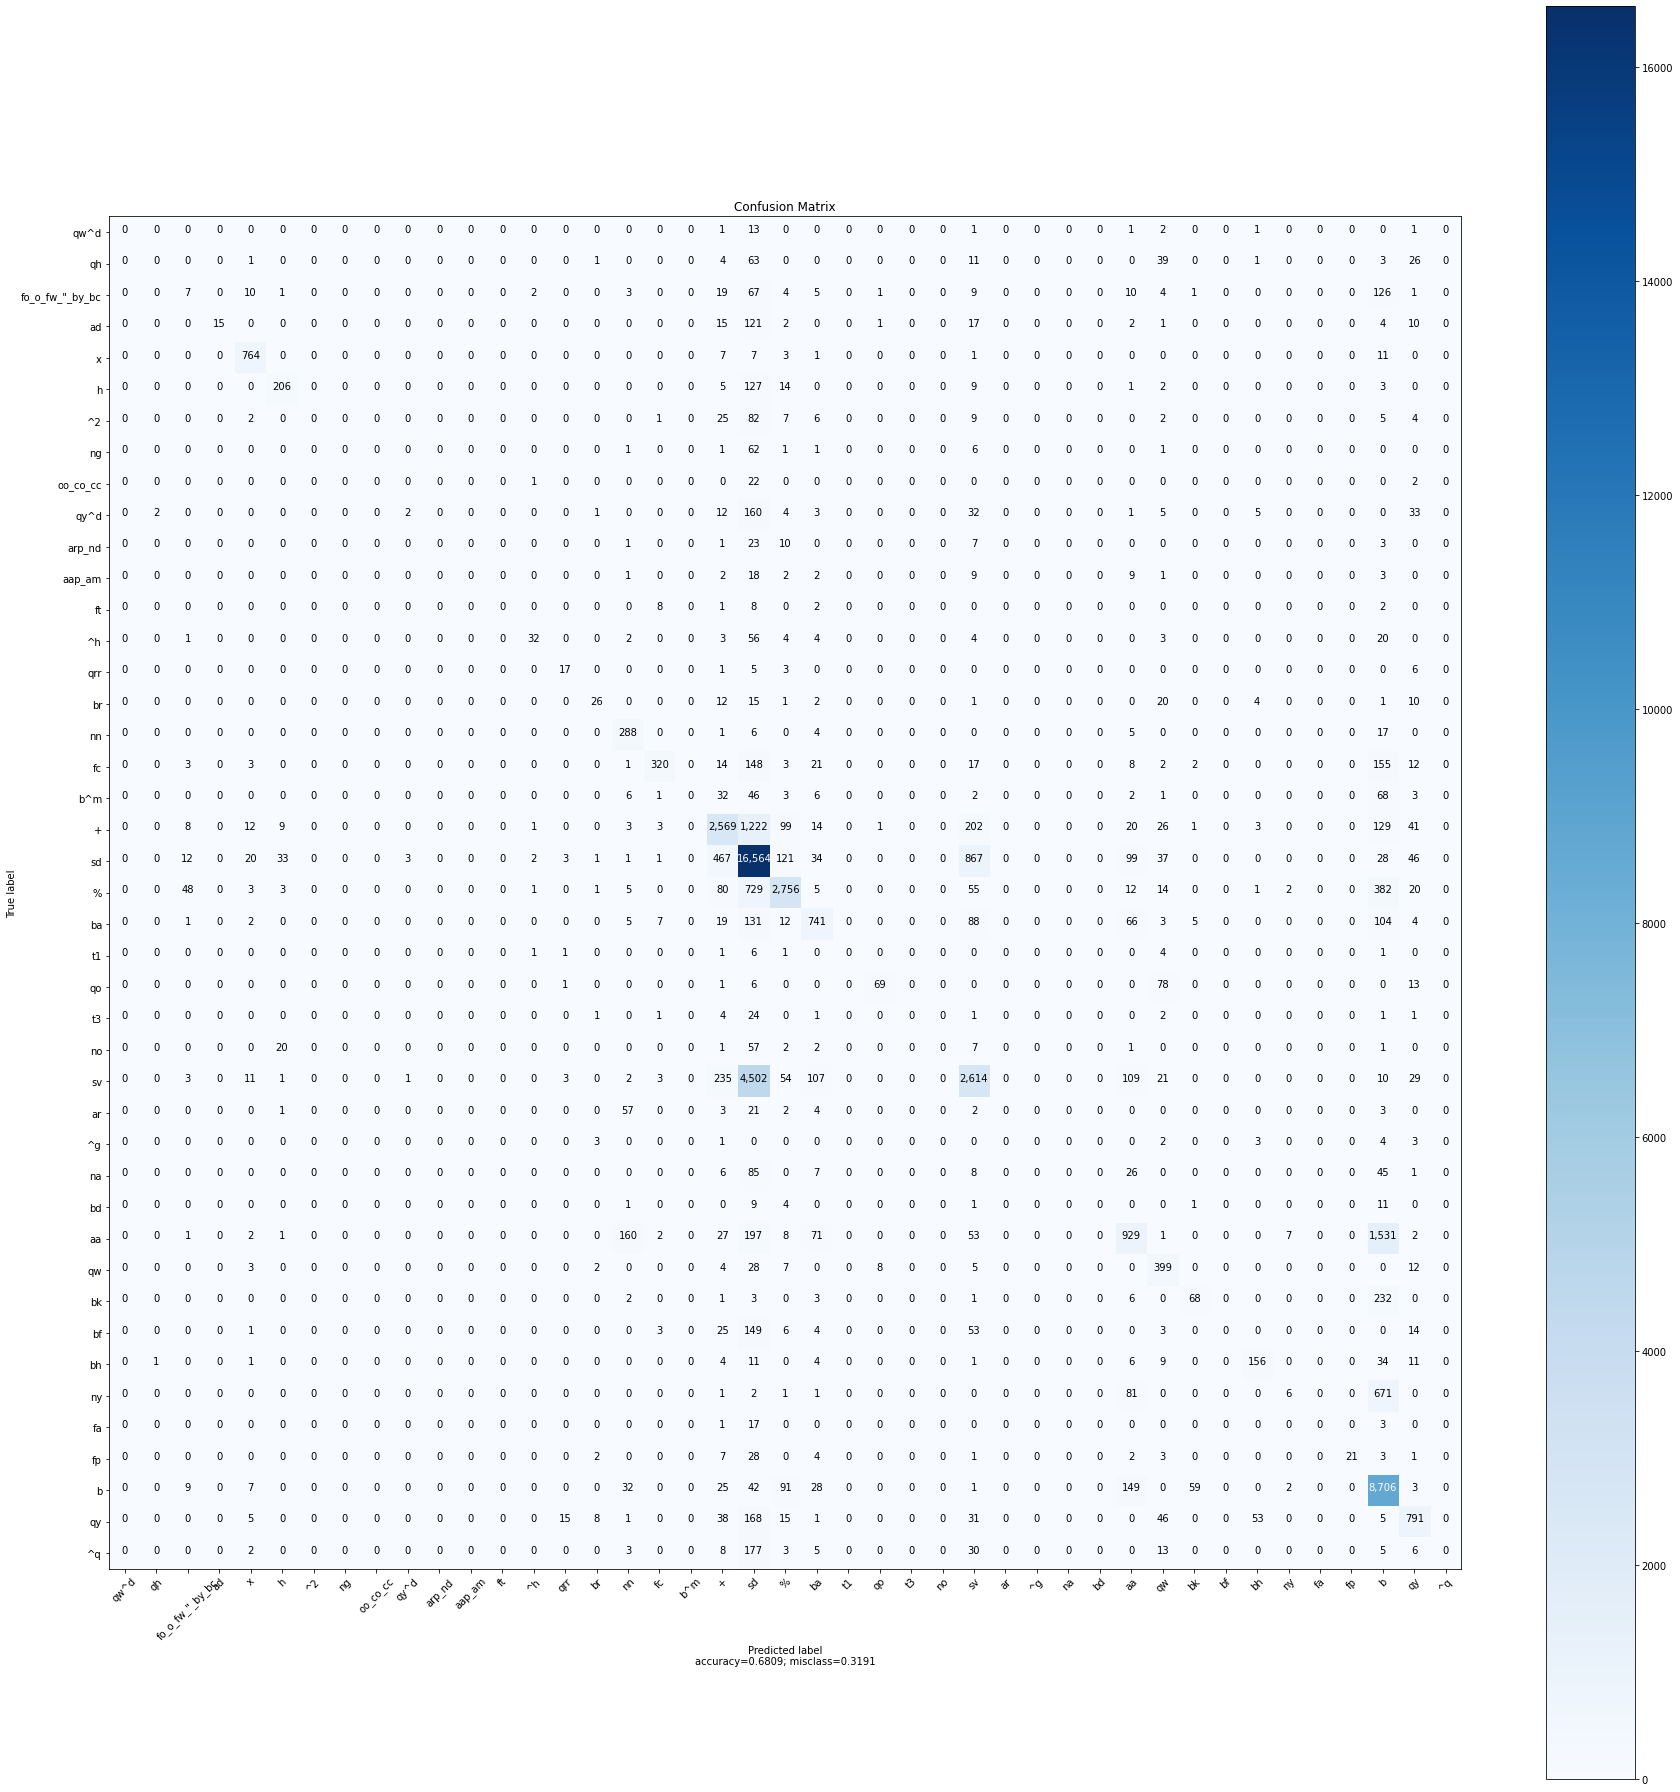

Position: 15
Instance : 92
Position: 35
Instance : 258
accuracy of br is : 0.2826086956521739
accuracy of bf is : 0.0


In [45]:
# Build the confusion matrix off these predictions

matrix_cnn = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred_cnn.argmax(axis=1))
plot_confusion_matrix(matrix_cnn,normalize    = False,
                      target_names = Classes_names,
                      title        = "Confusion Matrix")
# Calculate Accuracies for "br" and "bf"
accuracy_br = Cal_Accuracy_Minority('br',matrix_cnn)
accuracy_bf = Cal_Accuracy_Minority('bf',matrix_cnn)
print('accuracy of br is :',accuracy_br)
print('accuracy of bf is :',accuracy_bf)


<font color = "#75a2eb"><b>If we compare model 1 which was a simple model and model 3 in which we added context we can see that it performed better in the accuracy of br. This shows that adding context did certainly help in better prediction of minority classes. In the above code block we can see the sentences which were incorrectly classified with no context but were correctly classified with context. We can also see that the model struggles with smaller sentences and that's where it makes most mistakes.</b></font>

<font color = "#75a2eb"><b> Here the accuracy of the minority classes decreased again with bf being completely zero. This shows that bf is probably in even more minority than br. However, the overall accuracy of the model improved compared to both models.</b></font>